In [4]:
import matplotlib.pyplot as plt
import numpy as np
from commpy.modulation import QAMModem

from pyfiles.dsp import pulseShape, firFilter, decimate, symbolSync, resample
from pyfiles.models import phaseNoise, KramersKronigRx, linFiberCh
from pyfiles.tx import simpleWDMTx
from pyfiles.core import parameters
from pyfiles.equalization import edc, mimoAdaptEqualizer
from pyfiles.carrierRecovery import cpr
from pyfiles.metrics import fastBERcalc, monteCarloGMI, monteCarloMI, signal_power
from pyfiles.plot import pconst

import scipy.constants as const

In [37]:
plt.rcParams['font.size'] = 14
plt.rcParams['lines.linewidth'] = 2

# Simulation of coherent transmission

## **Transmitter**
**Simulation of a single polarization optical signal transmission**

In [38]:
## Transmitter parameters:
paramTx = parameters()
paramTx.M = 16                 # order of the modulation format
paramTx.Rs = 32e9              # symbol rate [baud]
paramTx.SpS = 4                # samples per symbol
paramTx.Nbits = 400000         # total number of bits per polarization
paramTx.pulse = "rrc"          # pulse shaping filter
paramTx.Ntaps = 1024           # number of pulse shaping filter coefficients
paramTx.alphaRRC = 0.01        # RRC rolloff
paramTx.Pch_dBm = 0            # power of the optical signal [dBm]
paramTx.Nch = 1                # number of WDM channels
paramTx.Fc = 193.1e12          # central frequency of the optical spectrum
paramTx.freqSpac = 37.5e9      # WDM grid spacing

## Optical channel parameters:
Ltotal = 55      # total link distance [km]
alpha = 0        # fiber loss parameter [dB/km]
D = 16           # fiber dispersion parameter [ps/nm/km]
Fc = paramTx.Fc  # central optical frequency of the WDM spectrum [Hz]

## Receiver parameters:

# local oscillator (LO)
FO = paramTx.Rs/2  # frequency offset
lw = 0*200e3       # linewidth
ϕ_lo = 0           # initial phase in rad
Plo_dBm = 12        # power in dBm

# ADC sampling rate
paramADC = parameters()
paramADC.Rs = paramTx.Rs
paramADC.SpS_in = paramTx.SpS
paramADC.SpS_out = 2

## General simulation parameters:
chIndex = 0  # index of the channel to be demodulated
plotPSD = True
Fs = paramTx.Rs * paramTx.SpS  # simulation sampling rate

In [39]:
def Generate_LO(sigCh):
    # generate LO field
    π = np.pi
    t = np.arange(0, len(sigCh))*Ts
    ϕ_pn_lo = phaseNoise(lw, len(sigCh), Ts)

    sigLO = np.sqrt(Plo) * np.exp(-1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))

    # Add LO to the received signal
    sigRx = np.sqrt(Plo) + sigCh * np.exp(1j * (2 * π * FO * t + ϕ_lo + ϕ_pn_lo))
    sfm = sigRx.copy()

    return sfm, sigRx

In [40]:
# generate optical signal signal
sigTx, symbTx_, paramTx = simpleWDMTx(paramTx)

# simulate linear signal propagation
sigCh_0 = linFiberCh(sigTx, Ltotal, alpha, D, Fc, Fs)
# addition of multiple dispersions
sigCh_1 = linFiberCh(sigTx, 25, alpha, D, Fc, Fs)
sigCh_2 = linFiberCh(sigTx, 35, alpha, D, Fc, Fs)
sigCh_3 = linFiberCh(sigTx, 55, alpha, D, Fc, Fs)

# receiver detection and demodulation
Fc = paramTx.Fc
Ts = 1 / Fs
mod = QAMModem(m=paramTx.M)

freqGrid = paramTx.freqGrid
print(
    "Demodulating channel #%d , fc: %.4f THz, λ: %.4f nm\n"
    % (
        chIndex,
        (Fc + freqGrid[chIndex]) / 1e12,
        const.c / (Fc + freqGrid[chIndex]) / 1e-9,
    )
)

symbTx = symbTx_[:, :, chIndex]
Plo = 10 ** (Plo_dBm / 10) * 1e-3  # power in W

print(
    "Local oscillator P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz"
    % (Plo_dBm, lw / 1e3, FO / 1e6)
)

# add LO to the received signal
sigRx_0, sfm_0 = Generate_LO(sigCh_0)
sigRx_1, sfm_1 = Generate_LO(sigCh_1)
sigRx_2, sfm_2 = Generate_LO(sigCh_2)
sigRx_3, sfm_3 = Generate_LO(sigCh_3)

channel 0	 fc : 193.1000 THz
  mode #0	 power: 0.00 dBm
channel 0	 power: 0.00 dBm

total WDM dignal power: 0.00 dBm
Demodulating channel #0 , fc: 193.1000 THz, λ: 1552.5244 nm

Local oscillator P: 12.00 dBm, lw: 0.00 kHz, FO: 16000.00 MHz


# Phase-retrieval stage

**Simulation of an ideal direct sensing optical receiver**

In [41]:
def intensity_values(sigRx):
    Amp = np.abs(sigRx)
    Amp = resample(Amp, paramADC)

    return Amp

In [42]:
def downshift(sigRx):
    π = np.pi
    
    t = np.arange(0, len(sigRx))*(1/newFs)
    sigRx *= np.exp(-1j * (2 * π * FO * t))
    
    return sigRx

In [43]:
def phase_ambiguity(sigCh, sigRx):

    rot = np.mean(sigCh/sigRx)
    sigRx = rot * sigRx_0
    sigRx = sigRx / np.sqrt(signal_power(sigRx))

    return sigRx

In [44]:
def calc_interference(sigCh, sigRx):
    intf = sigRx/np.sqrt(signal_power(sigRx))-sigCh/np.sqrt(signal_power(sigCh))
    SIR = 1/signal_power(intf)

    return SIR

In [45]:
# resampling to ADC sampling rate
sigCh_0 = resample(sigCh_0, paramADC)
sigCh_1 = resample(sigCh_1, paramADC)
sigCh_2 = resample(sigCh_2, paramADC)
sigCh_3 = resample(sigCh_3, paramADC)

sfm_0 = resample(sfm_0, paramADC)
sfm_1 = resample(sfm_1, paramADC)
sfm_2 = resample(sfm_2, paramADC)
sfm_3 = resample(sfm_3, paramADC)
newFs = paramADC.SpS_out*paramTx.Rs

Amp_0 = intensity_values(sigRx_0)
Amp_1 = intensity_values(sigRx_1)
Amp_2 = intensity_values(sigRx_2)
Amp_3 = intensity_values(sigRx_3)

# Kramers-Kronig phase-retrieval
phiTime_0 = KramersKronigRx(Amp_0, newFs)
phiTime_1 = KramersKronigRx(Amp_1, newFs)
phiTime_2 = KramersKronigRx(Amp_2, newFs)
phiTime_3 = KramersKronigRx(Amp_3, newFs)

# optical field reconstruction
sigRx_0 = Amp_0*np.exp(1j*phiTime_0)
sigRx_1 = Amp_1*np.exp(1j*phiTime_1)
sigRx_2 = Amp_2*np.exp(1j*phiTime_2)
sigRx_3 = Amp_3*np.exp(1j*phiTime_3)

# remove DC level
sigRx_0 -= np.sqrt(Plo)
sigRx_1 -= np.sqrt(Plo)
sigRx_2 -= np.sqrt(Plo)
sigRx_3 -= np.sqrt(Plo)

# downshift to baseband
sigRx_0 = downshift(sigRx_0)
sigRx_1 = downshift(sigRx_1)
sigRx_2 = downshift(sigRx_2)
sigRx_3 = downshift(sigRx_3)

# correct for (possible) phase ambiguity
sigRx_0 = phase_ambiguity(sigCh_0, sigRx_0)
sigRx_1 = phase_ambiguity(sigCh_1, sigRx_1)
sigRx_2 = phase_ambiguity(sigCh_2, sigRx_2)
sigRx_3 = phase_ambiguity(sigCh_3, sigRx_3)

SIR_0 = calc_interference(sigCh_0, sigRx_0)
SIR_1 = calc_interference(sigCh_1, sigRx_1)
SIR_2 = calc_interference(sigCh_2, sigRx_2)
SIR_3 = calc_interference(sigCh_3, sigRx_3)

print('Rx_0 SIR = ', round(10*np.log10(SIR_0), 2), ' dB')
print('Rx_1 SIR = ', round(10*np.log10(SIR_1), 2), ' dB')
print('Rx_2 SIR = ', round(10*np.log10(SIR_2), 2), ' dB')
print('Rx_3 SIR = ', round(10*np.log10(SIR_3), 2), ' dB')

Rx_0 SIR =  17.31  dB
Rx_1 SIR =  -4.22  dB
Rx_2 SIR =  -3.86  dB
Rx_3 SIR =  -0.94  dB


# Standard receiver processing

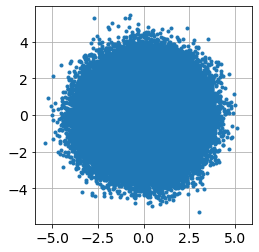

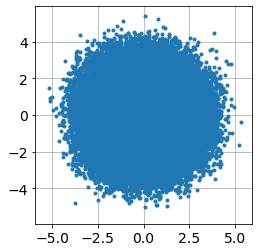

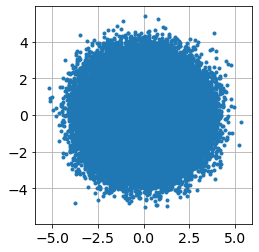

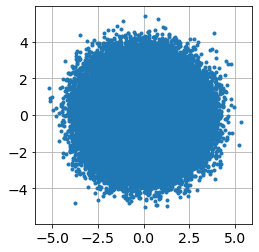

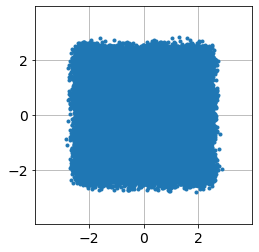

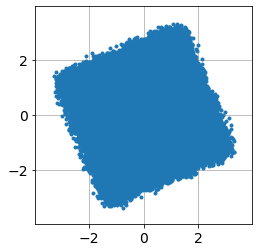

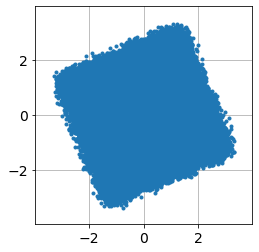

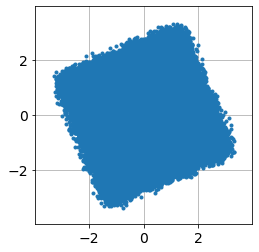

In [46]:
paramRes = parameters()
paramRes.Rs = paramTx.Rs
paramRes.SpS_in = paramADC.SpS_out
paramRes.SpS_out = 2

sigRx_0 = resample(sigRx_0, paramRes)
sigRx_1 = resample(sigRx_1, paramRes)
sigRx_2 = resample(sigRx_2, paramRes)
sigRx_3 = resample(sigRx_3, paramRes)
# Matched filtering and CD compensation

# Matched filtering
if paramTx.pulse == "nrz":
    pulse = pulseShape("nrz", paramADC.SpS_out)
elif paramTx.pulse == "rrc":
    pulse = pulseShape(
        "rrc", paramRes.SpS_out, N=paramTx.Ntaps, alpha=paramTx.alphaRRC, Ts=1 / paramTx.Rs
    )

pulse = pulse / np.max(np.abs(pulse))
sigRx_0 = firFilter(pulse, sigRx_0)
sigRx_1 = firFilter(pulse, sigRx_1)
sigRx_2 = firFilter(pulse, sigRx_2)
sigRx_3 = firFilter(pulse, sigRx_3)

# plot constellations after matched filtering
pconst(sigRx_0[0::paramRes.SpS_out], lim=True, R=3)
pconst(sigRx_1[0::paramRes.SpS_out], lim=True, R=3)
pconst(sigRx_2[0::paramRes.SpS_out], lim=True, R=3)
pconst(sigRx_3[0::paramRes.SpS_out], lim=True, R=3)

# CD compensation
sigRx_0 = edc(sigRx_0, Ltotal, D, Fc, paramRes.SpS_out*paramTx.Rs)
sigRx_1 = edc(sigRx_1, Ltotal, D, Fc, paramRes.SpS_out*paramTx.Rs)
sigRx_2 = edc(sigRx_2, Ltotal, D, Fc, paramRes.SpS_out*paramTx.Rs)
sigRx_3 = edc(sigRx_3, Ltotal, D, Fc, paramRes.SpS_out*paramTx.Rs)

#plot constellations after CD compensation
pconst(sigRx_0[0::paramRes.SpS_out], lim=True, R=2)
pconst(sigRx_1[0::paramRes.SpS_out], lim=True, R=2)
pconst(sigRx_2[0::paramRes.SpS_out], lim=True, R=2)
pconst(sigRx_3[0::paramRes.SpS_out], lim=True, R=2)

# Downsampling to 2 sps and re-synchronization with transmitted sequences
sigRx_0 = sigRx_0.reshape(-1, 1)
sigRx_1 = sigRx_1.reshape(-1, 1)
sigRx_2 = sigRx_2.reshape(-1, 1)
sigRx_3 = sigRx_3.reshape(-1, 1)

symbRx_0 = symbolSync(sigRx_0, symbTx, 2)
symbRx_1 = symbolSync(sigRx_1, symbTx, 2)
symbRx_2 = symbolSync(sigRx_2, symbTx, 2)
symbRx_3 = symbolSync(sigRx_3, symbTx, 2)

In [47]:
def power_normalization(sigRx, symbRx):
    
    x = sigRx
    d = symbRx

    x = x.reshape(len(x), 1) / np.sqrt(signal_power(x))
    d = d.reshape(len(d), 1) / np.sqrt(signal_power(d))

    return x, d



nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.005537.
nlms pre-convergence training iteration #1
nlms MSE = 0.003229.
nlms pre-convergence training iteration #2
nlms MSE = 0.003157.
nlms pre-convergence training iteration #3
nlms MSE = 0.003110.
nlms pre-convergence training iteration #4
nlms MSE = 0.003078.


dd-lms - training stage #1
dd-lms MSE = 0.002827.


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.053909.
nlms pre-convergence training iteration #1
nlms MSE = 0.003441.
nlms pre-convergence training iteration #2
nlms MSE = 0.003259.
nlms pre-convergence training iteration #3
nlms MSE = 0.003206.
nlms pre-convergence training iteration #4
nlms MSE = 0.003172.


dd-lms - training stage #1
dd-lms MSE = 0.002935.


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.053973.
nlms pre-convergence training iteration #1
nlms MSE = 0.003441.
nlms pre-convergence training iteration #2
nlms MSE = 0.003259.
nlms pre-convergence training iteration #3
nlms MSE = 0.003206.
nlms pre-convergence training iteration #4
nlms MSE = 0.003172.


dd-lms - training stage #1
dd-lms MSE = 0.002935.


nlms - training stage #0


  0%|          | 0/5 [00:00<?, ?it/s]

nlms pre-convergence training iteration #0
nlms MSE = 0.053925.
nlms pre-convergence training iteration #1
nlms MSE = 0.003441.
nlms pre-convergence training iteration #2
nlms MSE = 0.003259.
nlms pre-convergence training iteration #3
nlms MSE = 0.003206.
nlms pre-convergence training iteration #4
nlms MSE = 0.003172.


dd-lms - training stage #1
dd-lms MSE = 0.002935.


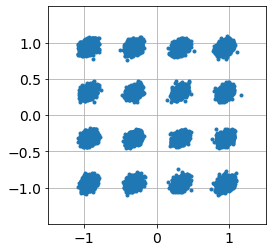

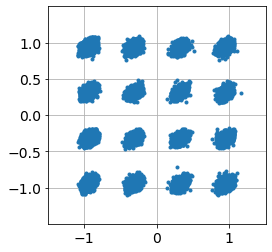

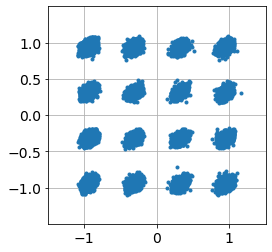

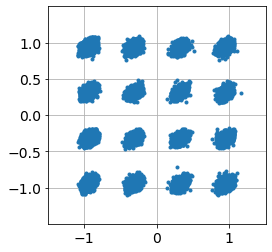

In [48]:
# Power normalization
x_0, d_0 = power_normalization(sigRx_0, symbRx_0)
x_1, d_1 = power_normalization(sigRx_1, symbRx_1)
x_2, d_2 = power_normalization(sigRx_2, symbRx_2)
x_3, d_3 = power_normalization(sigRx_3, symbRx_3)

# Adaptive equalization
mod = QAMModem(m=paramTx.M)

paramEq = parameters()
paramEq.nTaps = 15
paramEq.SpS = 2
paramEq.mu = [5e-3, 2e-3]
paramEq.numIter = 5
paramEq.storeCoeff = False
paramEq.alg = ["nlms", "dd-lms"]
paramEq.M = paramTx.M
paramEq.L = [20000, 80000]

y_EQ_0, H_0, errSq_0, Hiter_0 = mimoAdaptEqualizer(x_0, dx=d_0, paramEq=paramEq)
y_EQ_1, H_1, errSq_1, Hiter_1 = mimoAdaptEqualizer(x_1, dx=d_1, paramEq=paramEq)
y_EQ_2, H_2, errSq_2, Hiter_2 = mimoAdaptEqualizer(x_2, dx=d_2, paramEq=paramEq)
y_EQ_3, H_3, errSq_3, Hiter_3 = mimoAdaptEqualizer(x_3, dx=d_3, paramEq=paramEq)

discard = int(paramEq.L[0]/2)

#plot constellations after adaptive equalization
pconst(y_EQ_0[discard:-discard,:], lim=True)
pconst(y_EQ_1[discard:-discard,:], lim=True)
pconst(y_EQ_2[discard:-discard,:], lim=True)
pconst(y_EQ_3[discard:-discard,:], lim=True)

In [49]:
def pilotInd(y_EQ, d):
    paramCPR.pilotInd = np.arange(0, len(y_EQ), 20)
    y_CPR, θ = cpr(y_EQ, symbTx=d, paramCPR=paramCPR)
    y_CPR = y_CPR / np.sqrt(signal_power(y_CPR))

    return y_CPR, θ

In [50]:
def plot_CPR_estimated_phase(θ):
    
    plt.figure()
    plt.title("CPR estimated phase")
    plt.plot(θ, "-")
    plt.xlim(0, len(θ))
    plt.grid()

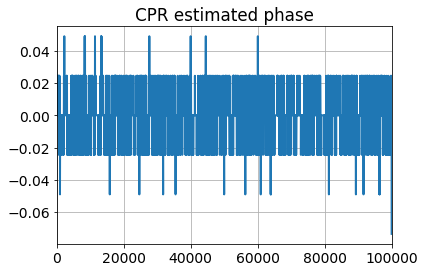

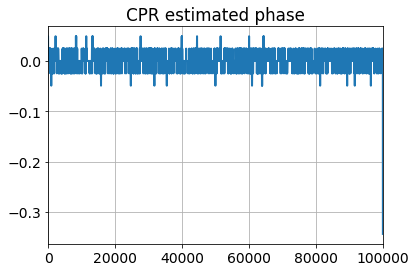

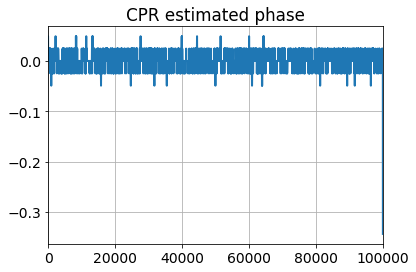

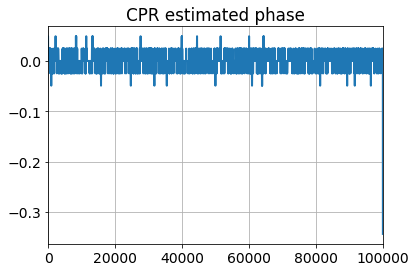

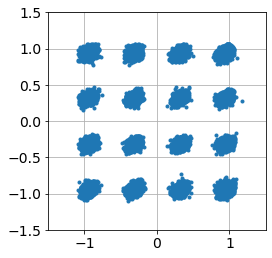

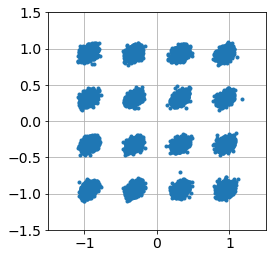

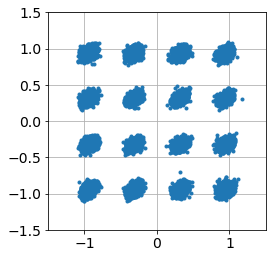

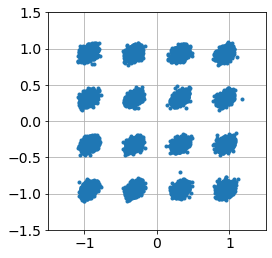

In [51]:
# Carrier phase recovery
paramCPR = parameters()
paramCPR.alg = "bps"
paramCPR.M = paramTx.M
paramCPR.N = 35
paramCPR.B = 64

y_CPR_0, θ_0 = pilotInd(y_EQ_0, d_0)
y_CPR_1, θ_1 = pilotInd(y_EQ_1, d_1)
y_CPR_2, θ_2 = pilotInd(y_EQ_2, d_2)
y_CPR_3, θ_3 = pilotInd(y_EQ_3, d_3)

plot_CPR_estimated_phase(θ_0)
plot_CPR_estimated_phase(θ_1)
plot_CPR_estimated_phase(θ_2)
plot_CPR_estimated_phase(θ_3)

discard = 5000

# plot constellations after CPR
pconst(y_CPR_0[discard:-discard, :], lim=True)
pconst(y_CPR_1[discard:-discard, :], lim=True)
pconst(y_CPR_2[discard:-discard, :], lim=True)
pconst(y_CPR_3[discard:-discard, :], lim=True)


# Evaluate transmission metrics

In [52]:
def evaluate_metrics(string, y_CPR, d, ind):
    
    BER, SER, SNR = fastBERcalc(y_CPR[ind, :], d[ind, :], mod)
    GMI, _ = monteCarloGMI(y_CPR[ind, :], d[ind, :], mod)
    MI = monteCarloMI(y_CPR[ind, :], d[ind, :], mod)

    print("Results \n"+string)
    print("SER: %.2e" % (SER[0]))
    print("BER: %.2e" % (BER[0]))
    print("SNR: %.2f dB" % (SNR[0]))
    print("MI: %.2f bits" % (MI[0]))
    print("GMI: %.2f bits" % (GMI[0]))


In [53]:
def ambiguity(y_CPR, d):

    for k in range(y_CPR.shape[1]):
        rot = np.mean(d[:, k] / y_CPR[:, k])
        y_CPR[:, k] = rot * y_CPR[:, k]

In [54]:
# correct for (possible) phase ambiguity
ambiguity(y_CPR_0, d_0)
ambiguity(y_CPR_1, d_1)
ambiguity(y_CPR_2, d_2)
ambiguity(y_CPR_3, d_3)

y_CPR_0 = y_CPR_0 / np.sqrt(signal_power(y_CPR_0))
y_CPR_1 = y_CPR_1 / np.sqrt(signal_power(y_CPR_1))
y_CPR_2 = y_CPR_2 / np.sqrt(signal_power(y_CPR_2))
y_CPR_3 = y_CPR_3 / np.sqrt(signal_power(y_CPR_3))

ind_0 = np.arange(discard, d_0.shape[0] - discard)
ind_1 = np.arange(discard, d_1.shape[0] - discard)
ind_2 = np.arange(discard, d_2.shape[0] - discard)
ind_3 = np.arange(discard, d_3.shape[0] - discard)

evaluate_metrics("Rx_0", y_CPR_0, d_0, ind_0)
evaluate_metrics("Rx_1", y_CPR_1, d_1, ind_1)
evaluate_metrics("Rx_2", y_CPR_2, d_2, ind_2)
evaluate_metrics("Rx_3", y_CPR_3, d_3, ind_3)

Results 
Rx_0
SER: 0.00e+00
BER: 0.00e+00
SNR: 25.55 dB
MI: 4.00 bits
GMI: 4.00 bits
Results 
Rx_1
SER: 0.00e+00
BER: 0.00e+00
SNR: 25.38 dB
MI: 4.00 bits
GMI: 4.00 bits
Results 
Rx_2
SER: 0.00e+00
BER: 0.00e+00
SNR: 25.38 dB
MI: 4.00 bits
GMI: 4.00 bits
Results 
Rx_3
SER: 0.00e+00
BER: 0.00e+00
SNR: 25.38 dB
MI: 4.00 bits
GMI: 4.00 bits


In [55]:
def plot_phase(sfm, phiTime):
    plt.figure(figsize=(10, 6))
    plt.plot(np.angle(sfm)[300:400], '-o', label='True')
    plt.plot(phiTime[300:400], 'x', label='KK')
    plt.legend()

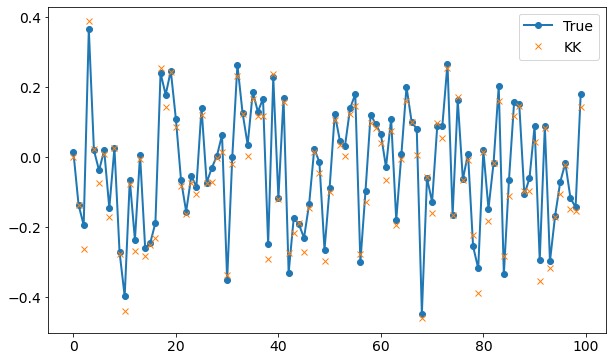

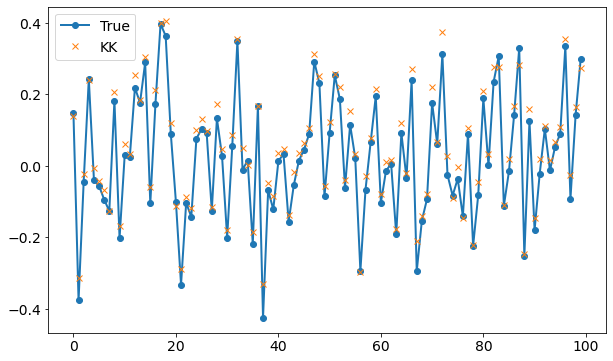

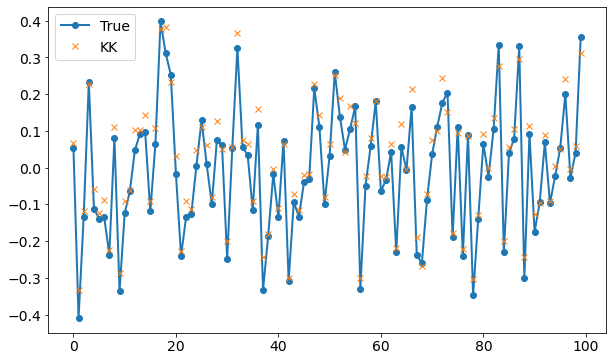

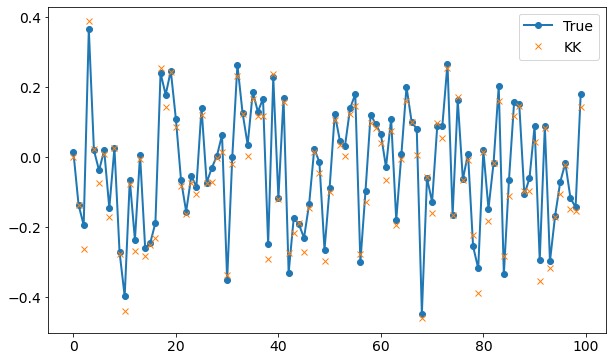

In [56]:
plot_phase(sfm_0, phiTime_0)
plot_phase(sfm_1, phiTime_1)
plot_phase(sfm_2, phiTime_2)
plot_phase(sfm_3, phiTime_3)